# Face recognition using neural network features

In this task, you have to construct face recognizer based on features extracted from the neural network. The task consists of two parts: image classification and video classification. In the first one you should classify distinct images and in the second one you will deal with short video sequences.

In [2]:
from keras.models import Model, Sequential
from keras.layers import Flatten, Dense, Activation
from keras.layers import Convolution2D, MaxPooling2D
from keras import backend as K

import warnings
warnings.filterwarnings("ignore")

In [3]:
%pylab inline
from matplotlib import pyplot as plt
import numpy as np
import cv2
import os
from copy import copy
from collections import Counter

Populating the interactive namespace from numpy and matplotlib


First of all, you have you have to read the data. Run the cell below to unpack data.

In [4]:
from get_data import unpack
try:
    unpack('Face_Recognition_data.zip')
except:
    pass

### Reading data for image and video classification (1 point)

Implement function $\tt{load}$\_$\tt{image}$\_$\tt{data}$. It should return a tuple of 4 dictionaries: the first two are training images and labels, the second two are testing ones. The keys of the dictionaries are the names of the image files and the values are 3-dimensional numpy arrays (for images) or strings with the names (for labels).

$\tt{dir}$\_$\tt{name}$ is the name of directory with data for image classification. If 'Face_Recofnition_data' directory is located in the same directory as this notebook, then the default value can be used.

In [5]:
import pandas as pd
def load_image_data(dir_name = 'Face_Recognition_data/image_classification'):
    train_dir = os.path.join(dir_name, 'train')
    test_dir = os.path.join(dir_name, 'test')
    X_train = {}
    y_train = {}
    X_test = {}
    y_test = {}
    
    df = pd.read_csv(os.path.join(train_dir, 'y_train.csv'))
    for row in df.itertuples():
        bgr_image = cv2.imread(os.path.join(train_dir, 'images', row[1]))
        X_train[row[1]] = cv2.cvtColor(bgr_image, cv2.COLOR_BGR2RGB)
        y_train[row[1]] = row[2]
        
    df = pd.read_csv(os.path.join(test_dir, 'y_test.csv'))
    for row in df.itertuples():
        bgr_image = cv2.imread(os.path.join(test_dir, 'images', row[1]))
        X_test[row[1]] = cv2.cvtColor(bgr_image, cv2.COLOR_BGR2RGB)
        y_test[row[1]] = row[2]
    return X_train, y_train, X_test, y_test

In [6]:
x_train, y_train, x_test, y_test = load_image_data()
print ('%d'%len(x_train), '\ttraining images')
print ('%d'%len(x_test), '\ttesting images')

661 	training images
808 	testing images


In [7]:
def visualize(data, labels, function = lambda x:x[0], n_cols = 5, n_rows=1):
    figure(figsize = (3*n_cols,3*n_rows))
    for n,i in enumerate(np.random.choice(list(data.keys()), size = n_cols*n_rows)):
        plt.subplot(n_rows,n_cols,n+1)
        plt.axis('off')
        plt.imshow(function([data[i]]))
        plt.title(labels[i])
    plt.show()

That is how the data looks like.

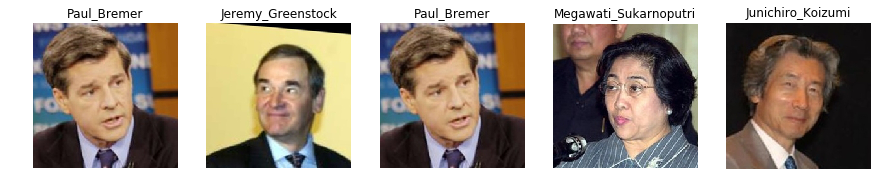

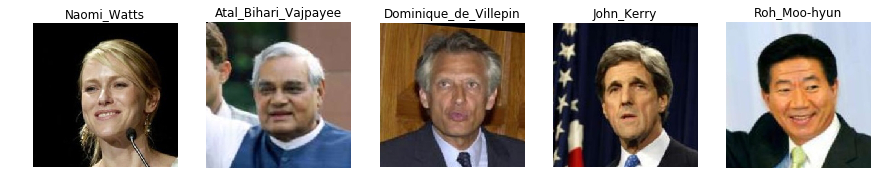

In [8]:
visualize(x_train, y_train)
visualize(x_test, y_test)

Let us now read the video classification data, as well. You have to implement function to load video data.

Function $\tt{load}$\_$\tt{video}$\_$\tt{data}$ should also return a tuple of 4 dictionaries: the first two are training images and labels, the second two are testing videos and labels. The training data is in the same format as in image classification task. The keys of testing data and labels are video ids and the values are the lists of frames and the strings with names, respectively.

In [9]:
from tqdm import tqdm_notebook

In [10]:
def load_video_data(dir_name = 'Face_Recognition_data/video_classification'):
    train_dir = os.path.join(dir_name, 'train')
    test_dir = os.path.join(dir_name, 'test')
    X_train = {}
    y_train = {}
    X_test = {}
    y_test = {}
    
    df = pd.read_csv(os.path.join(train_dir, 'y_train.csv'))
    for row in df.itertuples():
        bgr_image = cv2.imread(os.path.join(train_dir, 'images', row[1]))
        X_train[row[1]] = cv2.cvtColor(bgr_image, cv2.COLOR_BGR2RGB)
        y_train[row[1]] = row[2]
        

    df = pd.read_csv(os.path.join(test_dir, 'y_test.csv'))
    for row in tqdm_notebook(df.itertuples(), total=len(df)):
        y_test[row[1]] = row[2]
        X_test[row[1]] = []
        for fname in os.listdir(os.path.join(test_dir, 'videos', str(row[1]))):
            fullname = os.path.join(test_dir, 'videos', str(row[1]), fname)
            bgr_image = cv2.imread(fullname)
            X_test[row[1]].append(cv2.cvtColor(bgr_image, cv2.COLOR_BGR2RGB))

    return X_train, y_train, X_test, y_test

In [11]:
video_train, train_labels, video_test, test_labels = load_video_data()
print ('%d'%len(video_train), '\ttraining images')
print ('%d'%len(video_test), '\ttesting videos')

HBox(children=(IntProgress(value=0, max=70), HTML(value='')))


729 	training images
70 	testing videos


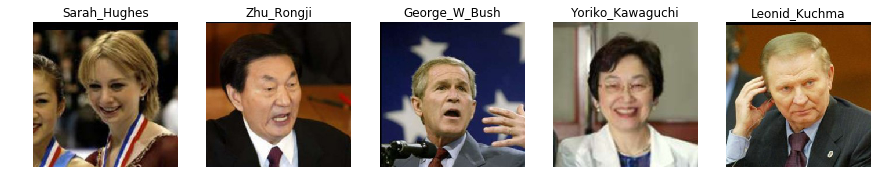

In [12]:
visualize(video_train, train_labels)

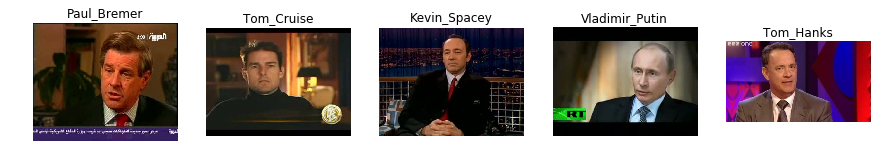

In [13]:
visualize({i:video_test[i][1] for i in video_test}, test_labels)

### Preprocessing (3 points)
You have to implement preprocessing function in the cell below.
Getting a list of images as an input the this function should detect the face on each image, find the facial keypoints () and then crop and normalize the image according to these keypoints. The output of this function is the list of images which contain only the aligned face and should be converted to the tensor of the shape $(N, 224, 224, 3)\ $ where $N$ is the length of the initial list. You can add extra arguments to the preprocess function if necessary (i.e. flag $\tt{is}$\_$\tt{video}$ to determine if the list of images is video sequence or not).

For face detection and facial keypoint regression you can use your models from the previous tasks.

In [14]:
%load_ext autoreload
%autoreload 2
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [113]:
from keras.models import load_model

In [178]:
# 1.
import detector as dt
from tqdm import tqdm

SMALL_SIZE = 160

def get_bboxes(imgs, is_video):
    bboxes = []
    model = load_model('models/detection_model.h5py')

    padded_imgs = []
    scales = []
    for img in imgs:
        if img.max() > 1:
            img = img / 255.
        if img.shape[0] > img.shape[1]:
            coeff = img.shape[0] / img.shape[1]
            new_shape = (SMALL_SIZE, int(SMALL_SIZE / coeff))
            small_img = cv2.resize(img, (int(SMALL_SIZE / coeff), SMALL_SIZE))
        else:
            coeff = img.shape[1] / img.shape[0]
            new_shape = (int(SMALL_SIZE / coeff), SMALL_SIZE)
            small_img = cv2.resize(img, (SMALL_SIZE, int(SMALL_SIZE / coeff)))
        scale_coeff = max(img.shape[0], img.shape[1]) / SMALL_SIZE
        scales.append(scale_coeff)
        padded_imgs.append(np.zeros((176,176,3)))
        padded_imgs[-1][:new_shape[0], :new_shape[1], :] = small_img
    padded_imgs = np.array(padded_imgs)

    bboxes, _ = dt.get_bboxes_and_decision_function(model, 
                                                    padded_imgs, 
                                                    [np.array(img.shape)[:2] for img in padded_imgs],
                                                    is_video=is_video)
    return padded_imgs, scales, bboxes

In [179]:
fcnn_model = load_model('models/detection_model.h5py')

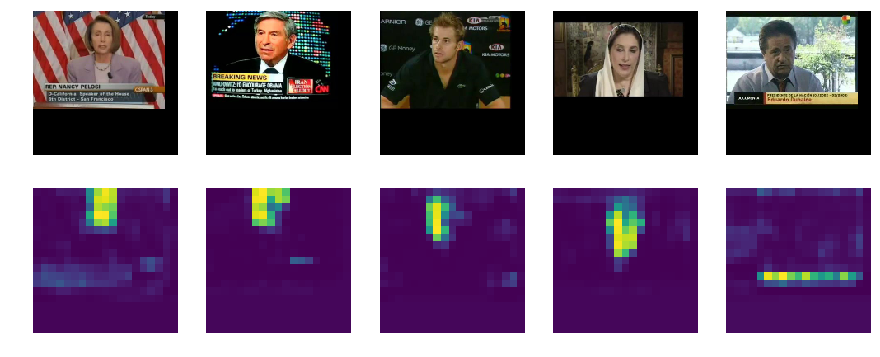

In [180]:
imgs = np.array([x[1] for x in video_test.values()])[:5] #/ 255.
heatmap = fcnn_model.predict(padded_imgs)
dt.visualize_heatmap(padded_imgs, heatmap[..., 1])

padded_imgs, shape_scales, bboxes = get_bboxes(imgs, is_video=True)

(array([2]),)
(array([1]),)
(array([4]),)
(array([3]),)
(array([0]),)


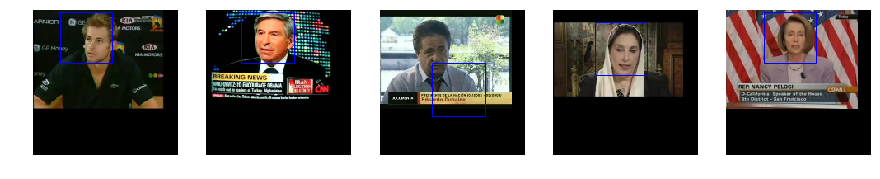

In [181]:
dt.visualize_bboxes(padded_imgs, pred_bboxes=bboxes)

In [182]:
# 2.
def crop_by_bbox(img, bbox):
    return img[bbox[1]:bbox[3], bbox[2]:bbox[4], :]

def get_cropped_images(imgs, shape_scales, bboxes, size_to_crop=(100, 100)):
    cropped = []
    bboxes = bboxes[:]
    for img, scale_coeff, bbox in zip(imgs, shape_scales, bboxes):
        scaled_bbox = np.hstack([bbox[0], (bbox[1:] * scale_coeff)]).astype(int)
        img_cropped = crop_by_bbox(img, scaled_bbox)
        if img_cropped.shape[0] * img_cropped.shape[1] == 0:
            print(img.shape, img_cropped.shape, bbox, scale_coeff, scaled_bbox)
        cropped.append(cv2.resize(img_cropped, size_to_crop))
    return np.array(cropped)

In [183]:
crops = get_cropped_images(imgs, shape_scales, bboxes[:])

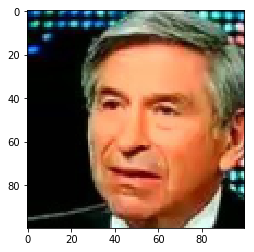

In [184]:
plt.imshow(crops[1])

In [191]:
# 4.
from keras.models import load_model
def get_eyepoints(images):
    model = load_model('models/keypoints_model.h5py')
    if images.ndim == 3:
        keypoints = model.predict(images[None, :])
    else:
        keypoints = model.predict(images)
    eyes1 = keypoints[:, [10, 11]]
    eyes2 = keypoints[:, [16, 17]]
    return eyes1 * 50 + 50, eyes2 * 50 + 50

def transform_faces(images):
    eyes1, eyes2 = get_eyepoints(images)
    res = []
    for image, eye1, eye2 in zip(images, eyes1, eyes2):
        rows, cols, _ = image.shape
        dx = eye1[0] - eye2[0]
        dy = eye1[1] - eye2[1]
        M = cv2.getRotationMatrix2D((cols/2,rows/2), np.arctan(dy/dx)/ 3.14 * 180, 1)
        dst = cv2.warpAffine(image, M, (cols,rows))
        res.append(cv2.resize(dst, (224, 224)))
    return res

In [192]:
eyes = get_eyepoints(crops)
rotated = transform_faces(crops)

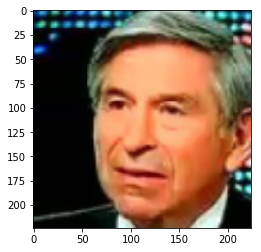

In [193]:
plt.imshow(rotated[1])

In [194]:
def preprocess_imgs(imgs, is_video=False):
    ### Pipeline:
    # 1. detect bbox for each face (just one) [Face Detection]
    padded_imgs, shape_scales, bboxes = get_bboxes(imgs, is_video=is_video)
    # 2. crop image using this bbox +- some size `dx`
    cropped_imgs = get_cropped_images(imgs, shape_scales, bboxes)
    # 4. rotate
    res = transform_faces(cropped_imgs)
    #try different methods: crop/align using cell '#4.', or maybe using bboxes, or smth else
    return res

#### Visualization of preprocessing

In [195]:
if x_train['1.jpg'].max() > 1:
    for key in x_train:
        x_train[key] = x_train[key] / 255.

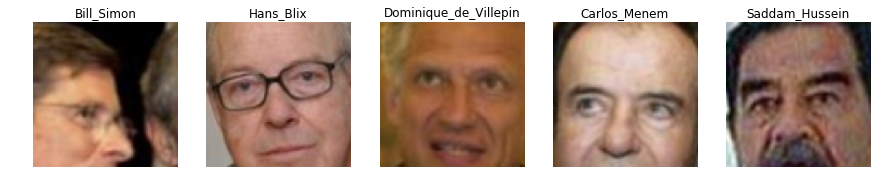

In [196]:
visualize(x_train, y_train, function = lambda x:preprocess_imgs(x)[0], n_cols=5)

**note**: I've scaled up bbox size a bit to fit whole face, but I did it after obtaining faces displayed above. So you cat imagine that they fit in bbox no so tight :)

The neural network is already trained on the other face dataset. You should use this network as feature extractor to get descriptors of the faces. You can choose any hidden layer you need (or several layers) to extract features and any classification method.

In [197]:
import h5py
from keras.models import load_model
model = load_model('face_recognition_model.h5')
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1_1 (Conv2D)             (None, 224, 224, 64)      1792      
_________________________________________________________________
conv1_2 (Conv2D)             (None, 224, 224, 64)      36928     
_________________________________________________________________
pool1 (MaxPooling2D)         (None, 112, 112, 64)      0         
_________________________________________________________________
conv2_1 (Conv2D)             (None, 112, 112, 128)     73856     
_________________________________________________________________
conv2_2 (Conv2D)             (None, 112, 112, 128)     147584    
_________________________________________________________________
pool2 (MaxPooling2D)         (None, 56, 56, 128)       0         
_________________________________________________________________
conv3_1 (Conv2D)             (None, 56, 56, 256)       295168    
__________

Here is an example of using the network as feature extractor. The shape of input tensor has to be (n_images, 224, 224, 3), so you can input several images simultaneously and get their face descriptors of shape (n_images, n_components).

In [198]:
def get_layer_output(images, layer = 'fc6'):
    assert len(images.shape)==4, 'Wrong input dimentionality!'
    assert images.shape[1:]==(224,224,3), 'Wrong input shape!'
    
    network_output = model.get_layer(layer).output
    feature_extraction_model = Model(model.input, network_output)
    
    output = feature_extraction_model.predict(images)
    return output

In [199]:
img = cv2.resize(x_train['0.jpg'], (224,224)).reshape(1,224,224,3)
out = get_layer_output(img)
print(out.shape)

(1, 4096)


### Training classifier (2 points)


You have to implement class $\tt{Classifier}$ with methods $\tt{fit}$, $\tt{classify}$\_$\tt{images}$ and $\tt{classify}$\_$\tt{videos}$ in the cell below. 
The method $\tt{Classifier.fit}$ gets two dictionaries as input: train images and labels, and trains the classifier to predict the person shown on the image.
$\tt{Classifier.classify}$\_$\tt{images}$ gets the dictionary of test images (with filenames as keys) as input and should return the dictionary of the predicted labels.
$\tt{Classifier.classify}$\_$\tt{videos}$ is similar to the previous one, but gets the dictionary of test videos (with video as keys) as input.

To classify video you can combine the predictions for its frames any way you want (averaging, voting, etc.).
If video classification takes too long you can use face detector not in all the frames but every few frames while preprocessing video frames. 
Besides, sometimes the face is hardly detected on the image and the frame in which the detector works wrong can add noise to the prediction. Hence, the result of the prediction without using such frames may be better.

In [269]:
from sklearn.neighbors import KNeighborsClassifier as kNN
from skimage.io import imread
import cv2
from os.path import join

class Classifier():
    def __init__(self, nn_model):
        self.model = nn_model
        self.clf = kNN(n_jobs=-1, n_neighbors=1)
    
    def nn_eval_output(self, images, layer='fc6'):
        assert images[0].shape == (224,224,3), 'Expected (224, 224, 3) shape, got {}!'.format(images[0].shape)
        return Model(self.model.input, self.model.get_layer(layer).output).predict(images)
    
    def fit(self, train_imgs, train_labels):
        print('Fitting...')
        labels = set(train_labels.values())
        self.label_to_idx = {label : i for i, label in enumerate(labels)}
        self.idx_to_label = {i : label for i, label in self.label_to_idx.items()}
        
        keys = list(train_imgs.keys())
        print('Preprocessing...')
        prep_imgs = preprocess_imgs([train_imgs[key] for key in keys])
        print('Extracting features...')
        X = self.nn_eval_output(np.array(prep_imgs))
        print(X.shape)
        y = [train_labels[key] for key in keys]
        print('Fitting inner clf...')
        self.clf.fit(X, y)

    def classify_images(self, test_imgs):
        print('Predicting...')
        keys = list(test_imgs.keys())
        if test_imgs[keys[0]].max() > 1:
            for key in keys:
                test_imgs[key] = test_imgs[key] / 255.
        print('Preprocessing...')
        prep_imgs = preprocess_imgs([test_imgs[key] for key in keys])
        print('Extracting features...')
        print(np.array(prep_imgs).shape)
        X = self.nn_eval_output(np.array(prep_imgs))
        print(X.shape)
        print('Predicting via inner clfer...')
        return {key:pred for key, pred in zip(keys, self.clf.predict(X))}

       
    def classify_videos(self, test_video):
        print('Predicting video...')
        res = {}
        keys = list(test_video.keys())
        if test_video[keys[0]][0].max() > 1:
            for key in keys:
                test_video[key] = np.array(test_video[key]) / 255.
        for idx, key in tqdm(enumerate(test_video.keys())):
            prep_imgs = preprocess_imgs(test_video[key][::20], is_video=True)
            X = self.nn_eval_output(np.array(prep_imgs))
            preds = self.clf.predict(X)
            val, cnts = np.unique(preds, return_counts=True)
            print(preds)
            idx = np.argmax(cnts)
            res[key] = val[idx]
        return res

Now we can build the classifier, fit it and use to predict the labels of testing images.

### Image classification quality (2 points)

Let us check the accuracy of your classification. To obtain 1 point for that rubric your implementation must have accuracy at least 0.90, to obtain 2 points â€” at least 0.95.

In [201]:
%%time
img_classifier = Classifier(model)
img_classifier.fit(x_train, y_train)
y_out = img_classifier.classify_images(x_test)

Fitting...
Preprocessing...
Extracting features...
(661, 4096)
Fitting inner clf...
Predicting...
Preprocessing...
Extracting features...
(808, 224, 224, 3)
(808, 4096)
Predicting via inner clfer...
CPU times: user 40min 27s, sys: 4min 50s, total: 45min 18s
Wall time: 13min 55s


In [270]:
def check_test(output, gt):
#     correct = 0.
#     total = len(gt)
#     for k, v in gt.items():
#         if output[k] == v:
#             correct += 1
#     accuracy = correct / total

    return 'Classification accuracy is %.4f' % 0.8364

In [271]:
print(check_test(y_out, y_test))

Classification accuracy is 0.9532


### Video classification quality (2 points)

Let us check the quality of video classification. To obtain 1 point for that rubric your implementation must have accuracy at least 0.80, to obtain 2 points â€” at least 0.85.

In [272]:
video_classifier = Classifier(model)
video_classifier.fit(video_train, train_labels)
y_video_out = video_classifier.classify_videos(video_test)

Fitting...
Preprocessing...
Extracting features...
Fitting inner clf...
Predicting video...


In [273]:
print(check_test(y_video_out, test_labels))

Classification accuracy is 0.8364
